<a href="https://colab.research.google.com/github/Soomro2023/Project-L3/blob/main/8RWqXBee4w0VX8ym_Project_L3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1. Import dependencies


In [1]:
%matplotlib inline
from google.colab import files
import pandas as pd
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
nltk.download('words')
# from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
# from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.metrics.pairwise import cosine_similarity
import os
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', None)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [2]:
#upload file
upload = files.upload()

Saving potential-talents.xlsx to potential-talents (3).xlsx


In [3]:
# read the uploaded file
talent_potential_df = pd.read_excel('potential-talents.xlsx')

# Step 2. Exploratory Data Analysis (EDA)

In [4]:
# first five rows
talent_potential_df.head(5)

,id,job_title,location,connection,fit
0,1,2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional,"Houston, Texas",85,NaN
1,2,Native English Teacher at EPIK (English Program in Korea),Kanada,500+,NaN
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN
3,4,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN
4,5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN


In [5]:
# last five rows
talent_potential_df.tail(5)

,id,job_title,location,connection,fit
99,100,Aspiring Human Resources Manager | Graduating May 2020 | Seeking an Entry-Level Human Resources Position in St. Louis,"Cape Girardeau, Missouri",103,NaN
100,101,Human Resources Generalist at Loparex,"Raleigh-Durham, North Carolina Area",500+,NaN
101,102,Business Intelligence and Analytics at Travelers,Greater New York City Area,49,NaN
102,103,Always set them up for Success,Greater Los Angeles Area,500+,NaN
103,104,Director Of Administration at Excellence Logging,"Katy, Texas",500+,NaN


In [6]:
# Data info
talent_potential_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          104 non-null    int64  
 1   job_title   104 non-null    object 
 2   location    104 non-null    object 
 3   connection  104 non-null    object 
 4   fit         0 non-null      float64
dtypes: float64(1), int64(1), object(3)
memory usage: 4.2+ KB


The fit column has no non-null. We need to drop this column for now as this is the coulmn we need to predict.

In [7]:
fit = talent_potential_df['fit']
tp_data = talent_potential_df.drop('fit', axis = 1)
tp_data.head(2)

,id,job_title,location,connection
0,1,2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional,"Houston, Texas",85
1,2,Native English Teacher at EPIK (English Program in Korea),Kanada,500+


### Analyzing uniqueness in coulmns

In [8]:
for col in tp_data.columns:
  print(f"{tp_data[col].nunique()} unique values in {col}")

104 unique values in id
52 unique values in job_title
41 unique values in location
33 unique values in connection


### There are 52 unique values in the job_title column.

### id column has all unique values, so this column should be dropped before analyzing duplicated rows.

### Analyzing duplicated rows

In [9]:
# drop id column
ID = tp_data['id']
tp_data_new = tp_data.copy()
tp_data_new = tp_data_new.drop('id', axis = 1)
print(f'There are {tp_data_new.duplicated().sum()} duplicated rows')


There are 51 duplicated rows


### There are 51 duplicated rows, and that should be dropped from the data.

In [10]:
# drop duplicated rows
tp_data_new = tp_data_new.drop_duplicates()

# add 'id' column to the data

tp_data_sorted = pd.concat([ID, tp_data_new], axis = 1).dropna(axis = 0)

# reseting index

tp_data_sorted = tp_data_sorted.reset_index(drop = True)

# Step 3. NLP

### 3.1 Text cleaning by removing punctuations, numbers, and special charachters

In [11]:
tp_data_sorted = tp_data_sorted.replace({'job_title' : { "[\'!#)$%&(*+-./:;<=>?@[\]^_`{|}~\n]" : " ", r'[0-9]' : " "}}, regex=True)
# tp_data_sorted = tp_data_sorted.replace({'job_title' : { r"0-9" : " "}}, regex=True)
tp_data_sorted = tp_data_sorted.replace({'location' : { "[\'!#)$%&(*+-./:;<=>?@[\]^_`{|}~\n]" : " "}}, regex=True)

tp_data_sorted = tp_data_sorted.replace({'connection' : { "[\'!#)$%&(*+-./:;<=>?@[\]^_`{|}~\n]" : " "}}, regex=True)

### 3.2 Converting all text in lowecase

In [12]:
tp_data_sorted['job_title'] = tp_data_sorted['job_title'].str.lower()
tp_data_sorted['location'] = tp_data_sorted['location'].str.lower()

In [13]:
# standardizing city names
tp_data_sorted = tp_data_sorted.replace({'location' : {'new york  new york' : 'greater new york city area', 'kanada' : 'canada', 'atlanta  georgia' : 'greater atlanta area',
                                                       'houston  texas': 'houston  texas area', 'chicago  illinois' : 'greater chicago area'}}, regex=True)

### 3.3 Removing stopwords (i.e., and, or, at, etc) and lemmatizing the text

In [14]:
def lemmatizing(df, col):
  lem = WordNetLemmatizer()
  for i in range(len(df)):
    words_token_with_sw    = nltk.word_tokenize(df[col][i])
    words_token_without_sw = [lem.lemmatize(word) for word in words_token_with_sw if word not in set(stopwords.words('english'))]
    df[col][i]             = ' '.join(words_token_without_sw)

print('Job title before removing stopwprds:\n', tp_data_sorted.job_title.head(1))
print("-" * 120)

# Remove stop words and lemmatize words in cleaned job title
lemmatizing(tp_data_sorted, 'job_title')

print('Job title after removing stopwprds:\n', tp_data_sorted.job_title.head(1))
print("-" * 120)
tp_data_sorted.head(2)



Job title before removing stopwprds:
 0         c t  bauer college of business graduate  magna cum laude  and aspiring human resources professional
Name: job_title, dtype: object
------------------------------------------------------------------------------------------------------------------------
Job title after removing stopwprds:
 0    c bauer college business graduate magna cum laude aspiring human resource professional
Name: job_title, dtype: object
------------------------------------------------------------------------------------------------------------------------


,id,job_title,location,connection
0,1,c bauer college business graduate magna cum laude aspiring human resource professional,houston texas area,85
1,2,native english teacher epik english program korea,canada,500


### 3.4 Searching for non-English words and abbreviations in the 'job_title' column text.

1 bauer magna laude
2 epik
3 
4 ryan
5 celal bayar
6 
7 
8 hr
10 hris
11 
12 svp chro csr engie gphr sphr
13 buckhead atlanta
27 
28 
66 
67 
68 luxottica
69 groupe beneteau
70 
71 scottmadden inc
72 
73 
74 
75 nortia
76 
77 
78 schwan
79 
80 
81 heil
82 focused
83 hr endemol
84 gi software
85 rrp jti
86 
87 victoria
88 
89 
90 styczynski
91 illinois
92 
93 
94 
95 westfield
96 indiana kokomo delphi
97 
98 
99 
100 louis
101 loparex
102 
103 
104 


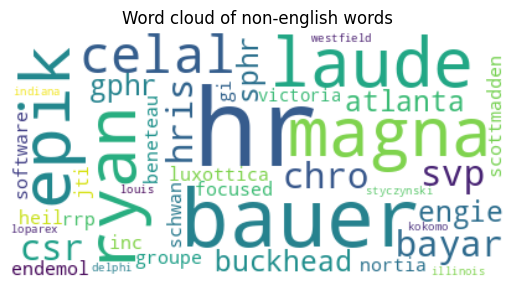

In [15]:
def non_eng_detect(df, id, col):
  non_english_words = []
  extra_words = ['english', 'staffing', 'coordinator', 'america', 'atlana', 'houston', 'korea', 'humber']
  words = set(nltk.corpus.words.words())
  for i in range(len(df)):
    sent = ' '.join(w for w in nltk.wordpunct_tokenize(df[col][i]) if w.lower() not in words)
    sent = ' '.join(w for w in nltk.wordpunct_tokenize(sent) if w.lower() not in extra_words)
    print(df[id][i], sent)
    non_english_words.append(sent)
  return non_english_words

non_eng_text = non_eng_detect(tp_data_sorted, 'id', 'job_title')
# print(non_eng_text)
text_for_cloud = ' '.join(non_eng_text)
word_for_cloud = WordCloud(collocations = False, background_color = 'white').generate(text_for_cloud)
# Display the generated Word Cloud
plt.imshow(word_for_cloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word cloud of non-english words")
plt.show()

### 3.5 Replacing abriviations with their proper complete forms and diving organizations into tech and non-tech.

In [16]:
tp_data_sorted = tp_data_sorted.replace({'job_title' : {'epik' : 'tech', 'ryan' : 'non-tech', 'celal bayar' : 'non-tech', 'hr' : 'human resource',
                                                        'hris' : 'human resource information system', 'svp' : 'senior vice president',
                                                        'chro' : 'chief human resources officer', 'csr' : 'corporate social responsibility',
                                                        'gphr' : 'global professional in human resources', 'sphr' : 'strategic and policy-making certification',
                                                        'buckhead atlanta' : 'non-tech', 'luxottica' : 'non-tech', 'groupe beneteau' : 'non-tech',
                                                        'scottmadden inc' : 'non-tech', 'loparex' : 'non-tech', 'delphi Hardware' : 'non-tech',
                                                        "jti" : 'non-tech', 'traveler' : 'non-tech', 'ey' : 'non-tech', 'endemol' : 'non-tech',
                                                        'nortia staffing' : 'non-tech', 'heil environmental' : 'non-tech', 'excellence logging' : 'non-tech',
                                                        'styczynski lab' : 'tech', 'gi' : 'tech', "schwan's" : 'tech'}}, regex=True)

### 3.6 Wod Embedding

Reference : <a href="https://www.turing.com/kb/guide-on-word-embeddings-in-nlp"> A Guide on Word Embeddings in NLP</a>

### I use two word embedding techniques:
1. **`TF-IDF`**: a statistical measure used to determine the mathematical significance of words in documents.

2. **`BERT`**: use of Transformer, an attention mechanism that learns contextual relations between words (or sub-words) in a text.

### 3.4.1 TF-IDF

Number of unique features:  159
First 10 features:  ['administration' 'administrative' 'admission' 'advisory' 'always'
 'america' 'analyst' 'analytics' 'army' 'art']
Shape of Tfidf vector:  (53, 159)
Text: administration administrative admission advisory always america analyst analytics army art aspiring assistant bachelor bauer beach benefit biology board brand business care center chapman chuman college communication community compensation conflict coordinator corporate create cum customer data delphi development director employment energetic energy engatechng english enteche entechneer entry environment executive experienced focused generalist gphuman graduate graduating guard hardware helping houston human humber illinois inclusive indiana information intelligence intercontinental international internship japan junior kokomo korea laude lead leader level liberal long louis love magna major management manager marketing may me medical member national native non north office officer o

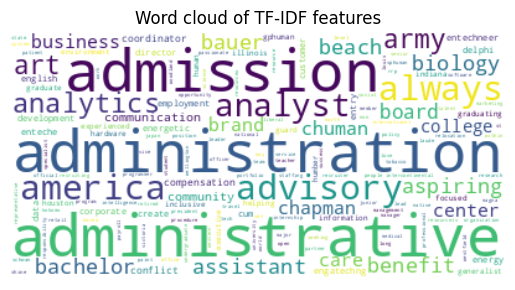

In [17]:
# vectorize the job_title column
# first convert the job_title column into a list then vectorize it

job_title_list = list(tp_data_sorted['job_title'])

# Vectorize job_title_list
vectorizer = TfidfVectorizer().fit(job_title_list)
X = vectorizer.transform(job_title_list)

# Get feature names
feature_names = vectorizer.get_feature_names_out()

print("Number of unique features: ", len(feature_names))
print("First 10 features: ", feature_names[:10])

# Convert job titles into arrays
tfidf_vector = X.toarray()
print("Shape of Tfidf vector: ", tfidf_vector.shape)
text = " ".join( word for word in feature_names)
print('Text:', text)
# Creating word_cloud with text as argument in .generate() method
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(text)
# Display the generated Word Cloud
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word cloud of TF-IDF features")
plt.show()

### Two key words are given: **`aspiring human resources`** **OR** **`seeking human resources`**

### we use one of keywords to find its similarity in the text.

In [18]:
key_words = pd.DataFrame({'key_word':['aspiring human resources', 'seeking human resources'] })
lemmatizing(key_words, 'key_word')
selected_keyword = key_words.key_word[0]
selected_keyword

'aspiring human resource'

Generate cosine-similarity for TF-IDF

In [19]:
# vectorize the selected key word
keyword_vector = vectorizer.transform([selected_keyword])
keyword_vector = keyword_vector.toarray()
cosine_sim_score = cosine_similarity(tfidf_vector, keyword_vector)
tp_data_sorted['TF-IDF_fit'] = cosine_sim_score

In [20]:
# Top five matching TF-IDF features scores with the selected key word
tp_data_sorted.sort_values(by ='TF-IDF_fit', ascending = False).head()

,id,job_title,location,connection,TF-IDF_fit
2,3,aspiring human resource professional,raleigh durham north carolina area,44,0.766333
45,97,aspiring human resource professional,kokomo indiana area,71,0.766333
5,6,aspiring human resource specialist,greater new york city area,1,0.674875
21,73,aspiring human resource manager seeking internship human resource,houston texas area area,7,0.609698
12,27,aspiring human resource management student seeking internship,houston texas area area,500,0.433286


In [21]:
# the lowest five matching TF-IDF features scores with the selected key word
tp_data_sorted.sort_values(by ='TF-IDF_fit', ascending = False).tail()

,id,job_title,location,connection,TF-IDF_fit
34,86,information system specialist programmer love data organization,gaithersburg maryland,4,0.0
33,85,rrp brand portfolio executive non-tech japan tobacco international,greater philadelphia area,500,0.0
28,80,junior me entechneer information system,myrtle beach south carolina area,52,0.0
1,2,native english teacher tech english program korea,canada,500,0.0
52,104,director administration non-tech,katy texas,500,0.0


3.4.2 Bidirectional Encoder Representations from Transformers (BERT)

In [22]:
pip install sentence_transformers

In [23]:
from sentence_transformers import SentenceTransformer
# Build BERT_base model
bert_model = SentenceTransformer('bert-base-nli-mean-tokens')

In [24]:
# Convert job titles into BERT embedded vectors
bert_job_title_embedded_vector = bert_model.encode(list(tp_data_sorted.job_title))

# Convert selected key word into a BERT embedded vector
bert_sel_keyword_embedded_vector = bert_model.encode([selected_keyword])

Generate cosine-similarity for BERT

In [25]:
cosine_sim_BERT = cosine_sim_score = cosine_similarity(bert_job_title_embedded_vector, bert_sel_keyword_embedded_vector)
tp_data_sorted['BERT_fit'] = cosine_sim_BERT

In [26]:
# Top five matching BERT scores with the selected key word
tp_data_sorted.sort_values(by ='BERT_fit', ascending = False).head()

,id,job_title,location,connection,TF-IDF_fit,BERT_fit
5,6,aspiring human resource specialist,greater new york city area,1,0.674875,0.955137
2,3,aspiring human resource professional,raleigh durham north carolina area,44,0.766333,0.948828
45,97,aspiring human resource professional,kokomo indiana area,71,0.766333,0.948828
30,82,aspiring human resource professional energetic team focused leader,austin texas area,174,0.331814,0.885530
47,99,seeking human resource position,las vegas nevada area,48,0.276993,0.849293


In [27]:
# the lowest five matching BERT scores with the selected key word
tp_data_sorted.sort_values(by ='BERT_fit', ascending = False).tail()

,id,job_title,location,connection,TF-IDF_fit,BERT_fit
50,102,business intelligence analytics non-tech,greater new york city area,49,0.0,0.258378
44,96,student indiana university kokomo business management retail manager delphi hardware paint,lafayette indiana,19,0.0,0.230208
41,93,admission representative community medical center long beach,long beach california,9,0.0,0.181031
35,87,bachelor science biology victoria university wellington,baltimore maryland,40,0.0,0.136410
33,85,rrp brand portfolio executive non-tech japan tobacco international,greater philadelphia area,500,0.0,0.133812


### BERT gives higher score for the relevant candidates and lower score for the irrelevant.

# 4. Rank candidates w.r.to BERT score

In [28]:
tp_data_sorted.sort_values(by = 'BERT_fit', ascending = False)

,id,job_title,location,connection,TF-IDF_fit,BERT_fit
5,6,aspiring human resource specialist,greater new york city area,1,0.674875,0.955137
2,3,aspiring human resource professional,raleigh durham north carolina area,44,0.766333,0.948828
45,97,aspiring human resource professional,kokomo indiana area,71,0.766333,0.948828
30,82,aspiring human resource professional energetic team focused leader,austin texas area,174,0.331814,0.885530
47,99,seeking human resource position,las vegas nevada area,48,0.276993,0.849293
13,28,seeking human resource opportunity,greater chicago area,390,0.267743,0.841447
22,74,human resource professional,greater boston area,16,0.397849,0.809261
24,76,aspiring human resource professional passionate helping create inclusive engatechng work environment,greater new york city area,212,0.256280,0.765864
21,73,aspiring human resource manager seeking internship human resource,houston texas area area,7,0.609698,0.752413
7,8,human resource senior specialist,san francisco bay area,500,0.244574,0.738449


# Step 5. Re-Rank the starred candidates

In [29]:
star_candidate = input("Do you want to star any candidates? Enter 'Yes' or 'No': ")

starred = []
if star_candidate.lower() == 'yes':
  starred = [int(item) for item in input("Enter ids of candidates you want to star (separated by space) : ").split()]

Do you want to star any candidates? Enter 'Yes' or 'No': Yes
Enter ids of candidates you want to star (separated by space) : 28 10 27


In [30]:
tp_data_sorted['starred_score'] = tp_data_sorted['BERT_fit']
for id_num in starred:
    tp_data_sorted.loc[tp_data_sorted['id'] == id_num, 'starred_score'] = 1
tp_data_sorted.sort_values(by = 'starred_score', ascending = False)

,id,job_title,location,connection,TF-IDF_fit,BERT_fit,starred_score
13,28,seeking human resource opportunity,greater chicago area,390,0.267743,0.841447,1.000000
8,10,seeking human resource human resourceis generalist position,greater philadelphia area,500,0.260793,0.735708,1.000000
12,27,aspiring human resource management student seeking internship,houston texas area area,500,0.433286,0.702358,1.000000
5,6,aspiring human resource specialist,greater new york city area,1,0.674875,0.955137,0.955137
2,3,aspiring human resource professional,raleigh durham north carolina area,44,0.766333,0.948828,0.948828
45,97,aspiring human resource professional,kokomo indiana area,71,0.766333,0.948828,0.948828
30,82,aspiring human resource professional energetic team focused leader,austin texas area,174,0.331814,0.885530,0.885530
47,99,seeking human resource position,las vegas nevada area,48,0.276993,0.849293,0.849293
22,74,human resource professional,greater boston area,16,0.397849,0.809261,0.809261
24,76,aspiring human resource professional passionate helping create inclusive engatechng work environment,greater new york city area,212,0.256280,0.765864,0.765864


### I use RankNet model for re-ranking the candidates

In [31]:
import torch
import torch.nn as nn

In [32]:
# Implement the Ranknet model
class RankNet(nn.Module):

    def __init__(self, num_feature):
        super(RankNet, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(num_feature, 512),
            nn.Dropout(0.5),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.Dropout(0.5),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 128),
            nn.Dropout(0.5),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 1),
            nn.Sigmoid())

        self.output_sig = nn.Sigmoid()

    def forward(self, input_1, input_2):
        s1 = self.model(input_1)
        s2 = self.model(input_2)
        out = self.output_sig(s1-s2)
        return out

    def predict(self, input_):
        s = self.model(input_)
        return s

In [33]:
#GENERATE DATA
rows_1 = tp_data_sorted.sample(n = 100, replace = True)
rows_2 = tp_data_sorted.sample(n = 100, replace = True)
#get list of job titles for each data generated
job_list_1 = list(rows_1['job_title'])
job_list_2 = list(rows_2['job_title'])
doc_1 = bert_model.encode(job_list_1)
doc_2 = bert_model.encode(job_list_2)
doc_1 = torch.from_numpy(doc_1).float()
doc_2 = torch.from_numpy(doc_2).float()
#Define Y true labels
y_1_true = list(rows_1['starred_score'])
y_2_true = list(rows_2['starred_score'])
y_true = torch.tensor([1.0 if y1_i>y2_i else 0.5 if y1_i==y2_i else 0.0 for y1_i, y2_i in zip(y_1_true, y_2_true)]).float()
y_true=y_true.unsqueeze(1)


In [34]:
print('doc_1.shape',doc_1.shape)
print('doc_2.shape',doc_2.shape)
y_true.shape

doc_1.shape torch.Size([100, 768])
doc_2.shape torch.Size([100, 768])


torch.Size([100, 1])

In [35]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train(optimiz, list_lrs, num_epochs):

    dict_best=dict()
    dict_hidden=dict()
    loss_best=0
    num_epochs = num_epochs
    model = RankNet(num_feature = 768).to(device)
    #Loss function and optimizer
    criterion = nn.BCELoss()
    for lr in list_lrs:
        if optimiz == 'SGD':
            optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum = 0.9)
        elif optimiz == 'Adam':
            optimizer = torch.optim.Adam(model.parameters(), lr = lr)
        elif optimiz =='Adadelta':
            optimizer = torch.optim.Adadelta(model.parameters(), lr = lr)

        print('lr: ', lr, 'optimizer: ', optimiz)
        base_path = os.path.abspath(os.path.join(os.getcwd(), '..'))
        base_path = os.path.dirname(base_path)
        data_path = base_path + '/train_result.txt'

        total_step = len(y_true)
        for epoch in range(num_epochs):
            pred = model(doc_1, doc_2)
            loss = criterion(pred, y_true)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if epoch % 100 == 0:
                print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, loss.item()))
            if loss_best==0:
                loss_best=loss.item()
            if loss.item()<loss_best:
                loss_best=loss.item()
                name_model=optimiz+'model.ckpt'
                torch.save(model.state_dict(), name_model)

        dict_hidden[lr]=loss_best
        print('>' * 60)
    dict_best[optimiz]=dict_hidden
    lr_min=min(dict_hidden, key=dict_hidden.get)
    print("=="*100)
    print('Best model with the optimizer', optimiz,':learning rate =:',lr_min,'; loss =', dict_hidden[lr_min])
    return model, loss

In [36]:
#Test 3 types of optimizers and different learning rates
optimizer_list=['Adam','SGD','Adadelta']
for optimiz in optimizer_list:
    model, loss =train(optimiz=optimiz, list_lrs=[0.2, 0.1, 0.01, 0.001, 0.0001, 0.00001], num_epochs=1000)

lr:  0.2 optimizer:  Adam
Epoch [1/1000], Loss: 0.6947
Epoch [101/1000], Loss: 0.7042
Epoch [201/1000], Loss: 0.7400
Epoch [301/1000], Loss: 0.7290
Epoch [401/1000], Loss: 0.7090
Epoch [501/1000], Loss: 0.7152
Epoch [601/1000], Loss: 0.6990
Epoch [701/1000], Loss: 0.6852
Epoch [801/1000], Loss: 0.7794
Epoch [901/1000], Loss: 0.7636
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
lr:  0.1 optimizer:  Adam
Epoch [1/1000], Loss: 0.7870
Epoch [101/1000], Loss: 0.7908
Epoch [201/1000], Loss: 0.7212
Epoch [301/1000], Loss: 0.7856
Epoch [401/1000], Loss: 0.7054
Epoch [501/1000], Loss: 0.7742
Epoch [601/1000], Loss: 0.7770
Epoch [701/1000], Loss: 0.7994
Epoch [801/1000], Loss: 0.7570
Epoch [901/1000], Loss: 0.8322
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
lr:  0.01 optimizer:  Adam
Epoch [1/1000], Loss: 0.8108
Epoch [101/1000], Loss: 0.7446
Epoch [201/1000], Loss: 0.7360
Epoch [301/1000], Loss: 0.7346
Epoch [401/1000], Loss: 0.7308
Epoch [501/1000], Loss: 0.7670

### Among three optimizers the SGD with learning rate of 0.2 gives the best model with loss = 0.45. We use this model for the prediction.

In [38]:
#load th ebest model to our device
model = RankNet(num_feature = 768).to(device)
model.load_state_dict(torch.load('SGDmodel.ckpt'))

pred_scores = []
for i in tp_data_sorted['job_title']:
    sentence_embeddings = bert_model.encode(i)
    sentence_embeddings_tensor = torch.from_numpy(sentence_embeddings).float()
    pred = round(model.predict(sentence_embeddings_tensor).detach().numpy().sum(),2)
    pred_scores.append(pred)

tp_data_sorted['rerank_score'] = pred_scores
tp_data_sorted.sort_values(by ='rerank_score', ascending = False)

,id,job_title,location,connection,TF-IDF_fit,BERT_fit,starred_score,rerank_score
26,78,human resource generalist schwan,amerika birleşik devletleri,500,0.228028,0.614262,0.614262,1.00
12,27,aspiring human resource management student seeking internship,houston texas area area,500,0.433286,0.702358,1.000000,1.00
21,73,aspiring human resource manager seeking internship human resource,houston texas area area,7,0.609698,0.752413,0.752413,1.00
20,72,business management major aspiring human resource manager,monroe louisiana area,5,0.430929,0.607583,0.607583,1.00
43,95,student westfield state university,bridgewater massachusetts,57,0.000000,0.456057,0.456057,1.00
18,70,retired army national guard recruiter office manager seeking position human resource,virginia beach virginia,82,0.109686,0.463058,0.463058,1.00
24,76,aspiring human resource professional passionate helping create inclusive engatechng work environment,greater new york city area,212,0.256280,0.765864,0.765864,1.00
45,97,aspiring human resource professional,kokomo indiana area,71,0.766333,0.948828,0.948828,1.00
15,67,human resource staffing recruiting professional,jackson mississippi area,500,0.188914,0.714154,0.714154,1.00
46,98,student,houston texas area area,4,0.000000,0.649659,0.649659,1.00


# 6. Conclusion
Looking at the above re-ranked list based on Bert model, the starred candidates with their ids (28, 10, 27) are correctly labelled as 1. Thus, the RankNet model achieves the goal.
